In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient
from finvizfinance.screener.overview import Overview
import alpaca_trade_api as tradeapi
import datetime
from sklearn.metrics import mean_squared_error
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/Users/freddieeisa/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Read your api key environment variable
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("news_api")
print(api_key)

f147b186a1504298a5fca6370fdcfe78


In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=os.environ["news_api"])

In [4]:
foverview = Overview()

filters_dict = {
    'Performance':'Today Up',
    'Price':"Under $2", 
    'Relative Volume': "Over 5"
}
foverview.set_filter(filters_dict=filters_dict)

tickers = foverview.ScreenerView()
#tickers.sort_values(by='Volume', inplace=True, ascending=False)
tickers.set_index('Ticker', inplace=True )
tickers.head(8)

,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
Ticker,,,,,,,,,
NEPT,Neptune Wellness Solutions Inc.,Healthcare,Drug Manufacturers - Specialty & Generic,Canada,253810000.0,None,1.96,0.1667,44087769.0
WRN,Western Copper and Gold Corporation,Basic Materials,Other Industrial Metals & Mining,Canada,229160000.0,None,1.69,0.1818,3358816.0


In [5]:
def get_sentiment(company):
    stock_headlines = ( newsapi.get_everything(
    q=company,
    language='en',
    sort_by='relevancy'))

    sentiments = []

    for articles in stock_headlines['articles']:
        try:
            text = articles['content']
            results = analyzer.polarity_scores(text)
            compound = results['compound']
            pos = results['pos']
            neu = results['neu']
            neg = results['neg'] 

            #put data into sentiments
            sentiments.append({
                'text':text,
                'Compound':compound,
                'Positive':pos,
                'Negative':neg,
                'Neutral':neu})

        except AttributeError:
            pass
    fininal_sentiments = pd.DataFrame(sentiments)
    if not fininal_sentiments.empty:
        return(fininal_sentiments["Positive"].mean())
    else:
        return(0)

In [6]:
ticker_sentiment = [] 
for ticker in tickers.index: 
    sentiment = get_sentiment(tickers['Company'][ticker])
    print(sentiment)
    if float(sentiment) >= 0.05:
        ticker_sentiment.append(ticker)
        print(f"{ticker} does meets our sentiment requirement")
    else:
        print(f"{ticker} does not meet our sentiment requirement")

0.16199999999999995
NEPT does meets our sentiment requirement
0.0511
WRN does meets our sentiment requirement


In [7]:
### Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
#Set time frame for reporting stocks
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 2) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = 1) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')

In [9]:
# Set timeframe to '1D'
timeframe = "1D"

#Set timeframe for last 2 years
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp(next_day, tz="America/New_York").isoformat()

#Get ticker data
df_ticker = api.get_barset(
    ticker_sentiment,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.dropna(inplace=True)
df_ticker.tail()

NEPT                                WRN          \
                           open  high   low  close    volume  open    high   
time                                                                         
2021-02-12 00:00:00-05:00  2.65  2.90  2.58  2.775   4475787  1.33  1.3799   
2021-02-16 00:00:00-05:00  2.12  2.18  1.88  1.940  24164206  1.38  1.5100   
2021-02-17 00:00:00-05:00  1.95  1.97  1.68  1.730  27275771  1.52  1.5300   
2021-02-18 00:00:00-05:00  1.78  1.83  1.66  1.670  15931720  1.50  1.5210   
2021-02-19 00:00:00-05:00  1.73  1.99  1.65  1.950  43340376  1.48  1.6994   

                                                  
                              low close   volume  
time                                              
2021-02-12 00:00:00-05:00  1.3100  1.35   656624  
2021-02-16 00:00:00-05:00  1.3700  1.50  1587919  
2021-02-17 00:00:00-05:00  1.3750  1.46   995855  
2021-02-18 00:00:00-05:00  1.4000  1.42   664558  
2021-02-19 00:00:00-05:00  1.4501  1.67  3316885

In [10]:
df_ticker=df_ticker.loc[:, (slice(None), ['close'])]
df_ticker.head()

,CTXR,CYRN,DNN
,close,close,close
time,,,
2020-09-23 00:00:00-04:00,1.0200,0.9301,0.4195
2020-09-24 00:00:00-04:00,0.9692,1.0393,0.4113
2020-09-25 00:00:00-04:00,1.0100,1.0473,0.4184
2020-09-28 00:00:00-04:00,1.0550,1.0324,0.4270
2020-09-29 00:00:00-04:00,1.0450,1.0440,0.4100


In [30]:
ticker_list=df_ticker.columns.get_level_values(0)
ticker1 = []
for i in ticker_list: 
    if i not in ticker1: 
        ticker1.append(i) 
from panel.interact import interact
import panel as pn
pn.extension()

def choose_ticker(ChooseTicker):
    return ChooseTicker

interact(choose_ticker, ChooseTicker=ticker1)

Column
    [0] Column
        [0] Select(name='ChooseTicker', options=['CTXRclose', ...], value='CTXRclose')
    [1] Row
        [0] Markdown(str, name='interactive00007')

In [11]:
df_ticker.columns = [''.join(col) for col in df_ticker.columns]
df_ticker.head()

,CTXRclose,CYRNclose,DNNclose
time,,,
2020-09-23 00:00:00-04:00,1.0200,0.9301,0.4195
2020-09-24 00:00:00-04:00,0.9692,1.0393,0.4113
2020-09-25 00:00:00-04:00,1.0100,1.0473,0.4184
2020-09-28 00:00:00-04:00,1.0550,1.0324,0.4270
2020-09-29 00:00:00-04:00,1.0450,1.0440,0.4100


<AxesSubplot:xlabel='time'>

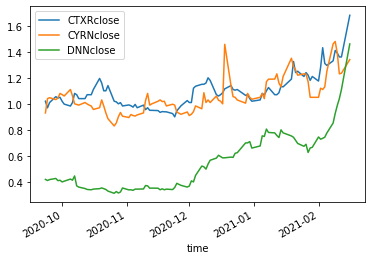

In [12]:
df_ticker.plot()

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [14]:
df_ticker['Return'] = df_ticker.iloc[:, [0]].pct_change() * 100
df_ticker['Lagged_Return'] = df_ticker.Return.shift()
df_ticker = df_ticker.dropna()
df_ticker.head()

,CTXRclose,CYRNclose,DNNclose,Return,Lagged_Return
time,,,,,
2020-09-25 00:00:00-04:00,1.010,1.0473,0.4184,4.209657,-4.980392
2020-09-28 00:00:00-04:00,1.055,1.0324,0.4270,4.455446,4.209657
2020-09-29 00:00:00-04:00,1.045,1.0440,0.4100,-0.947867,4.455446
2020-09-30 00:00:00-04:00,1.050,1.0800,0.4132,0.478469,-0.947867
2020-10-01 00:00:00-04:00,1.020,1.0711,0.4001,-2.857143,0.478469


In [1]:
# Create a train/test split for the data 
train = df_ticker['2018':'2020']
test = df_ticker['2021']

NameError: name 'df_ticker' is not defined

In [2]:
# Create train and test sets for dependent and independent variables
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

NameError: name 'train' is not defined

In [3]:
# Create and fit model to the data, make predictions
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

NameError: name 'LinearRegression' is not defined

In [18]:
# Construct a dataframe using just the "y" training data:
out_of_sample_results = y_test.to_frame()

# Add a column of "out-of-sample" predictions to that dataframe:  
out_of_sample_results["Out-of-Sample Predictions"] = model.predict(X_test)

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

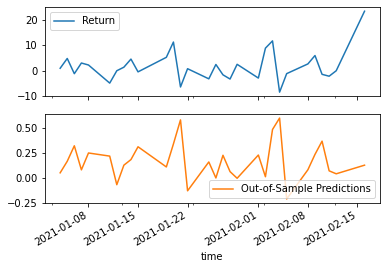

In [19]:
# Plot the out-of-sample results for 2019
out_of_sample_results.plot(subplots=True)

In [20]:
# Calculate out-of-sample mean_squared_error (for comparison to out-of-sample)
out_of_sample_mse = mean_squared_error(
    out_of_sample_results["Return"],
    out_of_sample_results["Out-of-Sample Predictions"]
)

# Calculate out-of-sample root mean_squared_error (for comparison to out-of-sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse:0.2f}")

Out-of-sample Root Mean Squared Error (RMSE): 6.37


In [21]:
# Split the index into weekly periods
weeks = df_ticker.index.to_period("w").unique()
print(weeks[0])

2020-09-21/2020-09-27


In [22]:
# Declare the training window of 12 weeks
# Define the imeframe of rolling windows
training_window = 12
timeframe = len(weeks) - training_window - 1
print(timeframe)

9


In [23]:
# Construct empty placeholder dataframes.
# (During each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [24]:
# During rolling iteration, split into train and test sets.
# Use linear regression to make out-of-sample predictions.
# Append the results to external dataframes.
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window+i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window + i + 1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df_ticker.loc[start_of_training_period:end_of_training_period]
    test = df_ticker.loc[start_of_test_week:end_of_test_week]
    
    # Create new dataframes:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary dataframe to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    
    # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    

In [25]:
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

,Actual Returns,Out-of-Sample Predictions
2020-12-21 00:00:00-05:00,2.242152,0.389788
2020-12-22 00:00:00-05:00,-2.631579,0.370339
2020-12-23 00:00:00-05:00,-0.450450,0.189036
2020-12-24 00:00:00-05:00,0.452489,0.270174
2020-12-28 00:00:00-05:00,-4.054054,0.218737


In [26]:
# 2019 Data
results_2019 = Results.loc['2019':]
results_2019.head()

,Actual Returns,Out-of-Sample Predictions
2020-12-21 00:00:00-05:00,2.242152,0.389788
2020-12-22 00:00:00-05:00,-2.631579,0.370339
2020-12-23 00:00:00-05:00,-0.450450,0.189036
2020-12-24 00:00:00-05:00,0.452489,0.270174
2020-12-28 00:00:00-05:00,-4.054054,0.218737


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

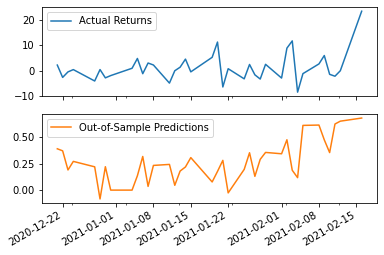

In [27]:
# Plot the results
results_2019.plot(subplots=True)

In [28]:
# Out-of-sample metrics
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    results_2019["Actual Returns"],
    results_2019["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rolling_rmse = np.sqrt(mse)
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse:0.2f}")

Rolling Out-of-Sample Root Mean Squared Error (RMSE): 5.68


In [29]:
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse:0.2f}")
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse:0.2f}")

Out-of-sample Root Mean Squared Error (RMSE): 6.37
Rolling Out-of-Sample Root Mean Squared Error (RMSE): 5.68
